#  <center> Problem Set 3 <center>
<center> Spring 2022 <center>
<center> 3.C01/3.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> Due: Thursday, March 17 at 10 PM ET <center>

<b>Name: Kaden DiMarco</b>

<b>Kerberos id: 923638043</b>

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

## <center>Problem 1: Predicting DNA Binding Sites</center>

In [ ]:
# Download data 
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/train_dna.csv

--2022-03-16 02:49:43--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/train_dna.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408340 (1.3M) [text/plain]
Saving to: ‘train_dna.csv’

train_dna.csv       100%[===================>]   1.34M  --.-KB/s    in 0.1s    

2022-03-16 02:49:43 (13.2 MB/s) - ‘train_dna.csv’ saved [1408340/1408340]



In [ ]:
train_pd = pd.read_csv("./train_dna.csv")

X = train_pd.seq.values
y = train_pd.bind.values



### 1.1 (15 points) Build Datasets and DataLoaders in PyTorch

One-hot encode DNA sequence data.

In [ ]:

def SeqEnc(sequences):
    # Write your one-hot encoding code here
    
    i = 0
    X = np.zeros((len(sequences),len(list(sequences[0])), 4))

    for sequence in sequences:
      seq_array = np.array(list(sequence))
      onehot_encoder = OneHotEncoder(sparse=False)
      label_encoder = LabelEncoder()
      integer_encoded_seq = label_encoder.fit_transform(seq_array)
      integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
      onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
      X[i,:,:] = onehot_encoded_seq
      i = i + 1
    # sequences - an array of DNA sequences as strings
    return X

X = SeqEnc(X)


Implement your dataset class that takes in your data.

In [ ]:
# Generate dataset 
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.y = torch.Tensor(y)  # store y as a pytorch Tensor
        self.len=len(self.X)      # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.y[index]
        # your implementation here: 

    def __len__(self):
        return self.len
    

Define your Datasets and DataLoaders.

In [ ]:
# Define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.1)


#Build Dataset 
train_data = SequenceDataset(X_subtrain, y_subtrain)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

# Build DataLoader 
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

What is the benefit of batching your data into mini-batches versus using the entire dataset to optimize the model all at once?

In [ ]:
#It is less computationally expensive and hyperparameters can be updated after each batch




### 1.2 (20 points) Build an LSTM-based binding classifier 

The following example will help familiarize you with the LSTM.

In [ ]:
# Define a LSTM module 
lstm_model = nn.LSTM(input_size=4, hidden_size=16, batch_first=True).to("cuda:0") # "cuda:0" is the device id

# Send your batch to a GPU 
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to("cuda:0")
y_batch = y_batch.to("cuda:0")

# Propagate your batch into your model 
lstm_out, (ht, ct) = lstm_model(X_batch) 
print(lstm_out.shape, ht.shape, ct.shape)

# You can play with hyperparameters to see how your output changes

torch.Size([256, 101, 16]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])


Now build your LSTM-based classifier as a nn.Module.

In [ ]:
class LSTMseq(torch.nn.Module) :
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        
        # Define a LSTM module
        self.lstm = torch.nn.LSTM(hidden_size=hidden_dim,input_size = input_dim, batch_first=True, num_layers=1, 
                                  bidirectional=True)
        # Define a MLP regressor 
        self.layers = []
        self.layers += [torch.nn.Linear(hidden_dim, hidden_dim)]
        self.layers += [torch.nn.Tanh()]
        self.layers += [torch.nn.Linear(hidden_dim, hidden_dim)]
        self.layers += [torch.nn.Tanh()]
        self.layers += [torch.nn.Linear(hidden_dim, 1)]

        self.mlp = torch.nn.Sequential(*self.layers)

        # Define a sigmoid transform
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        # Apply LSTM 
        output, (hn, cn) = self.lstm(x)
        # Pass output into a MLP
        
        out = self.mlp(hn[-1])
        # Transform output into probabilites 
        proba = self.sigmoid(out)
        # Return probabilities 
        
        return proba

In [ ]:
# Test your output on a batch 
clf = LSTMseq(input_dim=4, hidden_dim=16).to('cuda:0')
print(clf(X_batch).shape)

torch.Size([256, 1])


### 1.3 (25 points) Implement functions for training and testing

Your optimizer and scheduler.

In [ ]:
device = 'cuda:0'
model = LSTMseq(4, 16).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-2) # complete optimizer here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.5)

The training and validation loops and evaluation function.

In [ ]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        # train your model on each batch here
        y_pred = model(seq)
        loss = nn.functional.binary_cross_entropy(y_pred.squeeze(),label)
        batch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.array(batch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            
            # validate your model on each batch here 
            y_pred = model(seq)
            loss = nn.functional.binary_cross_entropy(y_pred.squeeze(),label)
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()   

def evaluate(model, dataloader, device):

    '''
    A function to return the classification probabilities and true labels (for evaluation). 
    
    Args: 
        model (torch.nn.Module): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true labels, predicted probabilities
    '''

    pred_prob = []
    labels = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            epoch_loss = []
            seq, label = batch

            seq = seq.to(device)
            label = label.to(device)
            
            # evaluate your model here
            model.eval()
            y_pred = model(seq)
            pred_prob.append(y_pred)
            labels.append(label)
            
    return labels, pred_prob

In [ ]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(500):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=0)
    
    # Validate your on validation data 
    val_loss = validate(model, val_loader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 0.694304300321115 0.6936508536338806
1 0.6934882176888956 0.6991436362266541
2 0.692695756216307 0.694964599609375
3 0.6927111793208767 0.6947281956672668
4 0.6929849901714841 0.6959660649299622
5 0.6924018376582378 0.7041188955307007
6 0.6922523041029234 0.6948846220970154
7 0.6894201958501661 0.6970101714134216
8 0.6849544692683864 0.6812469482421875
9 0.6791961998552889 0.6663454055786133
10 0.6590620440405768 0.6733089089393616
11 0.6564856767654419 0.6138591349124909
12 0.6919078198639123 0.6924593567848205
13 0.6889065117449373 0.6893395185470581
14 0.6783298398997333 0.6907616019248962
15 0.6957824310740909 0.6902656555175781
16 0.6924985743857719 0.691746461391449
17 0.6918448145325119 0.6917308568954468
18 0.6868556947321505 0.698892080783844
19 0.6944977689433742 0.698666799068451
20 0.6937617127959793 0.6946421384811401
21 0.6935710649232607 0.689134168624878
Epoch    23: reducing learning rate of group 0 to 5.0000e-03.
22 0.692728227860218

Plot train and validation loss functions.

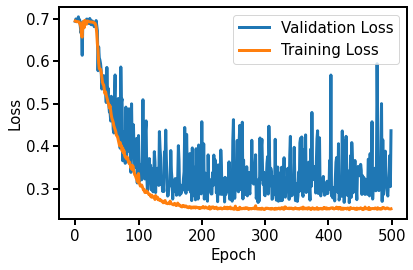

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(val_loss_curve, label='Validation Loss')
ax.plot(train_loss_curve, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
fig.tight_layout()

Report the AUC on test data.

In [ ]:
# Code to compute AUC on test data 
model.eval()

X_test_cuda = torch.Tensor(X_test).cuda()


y_pred = model(X_test_cuda)
y_pred = y_pred.cpu().detach().numpy()

test_score = sklearn.metrics.roc_auc_score(y_test, y_pred)
    
print("AUC on the test dataset is {}.".format(test_score) ) 

AUC on the test dataset is 0.9352685327990543.


## Part 2: Dimensionality Reduction for Molecular Representations

In [ ]:
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/drug.csv
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/morgan.csv

--2022-03-16 00:03:40--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/drug.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314383 (307K) [text/plain]
Saving to: ‘drug.csv’

drug.csv            100%[===================>] 307.01K  --.-KB/s    in 0.06s   

2022-03-16 00:03:40 (4.89 MB/s) - ‘drug.csv’ saved [314383/314383]

--2022-03-16 00:03:40--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/morgan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
# load data 
df = pd.read_csv("drug.csv")
fp = np.loadtxt('morgan.csv', delimiter=',')

assert fp.shape[0] == df.shape[0]


### 2.1 (10 points) Principal Component Analysis on Molecular Fingerprints

Perform PCA to reduce data into vectors of 100 dimensions.

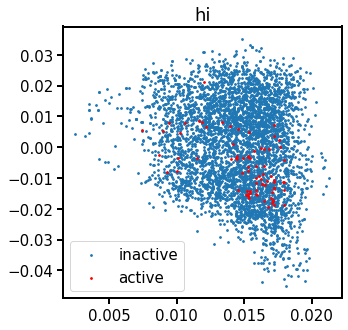

In [ ]:

# skeleton code for plotting

PCA = sklearn.decomposition.PCA(n_components = 100)
PCA.fit(fp.transpose())
components = PCA.components_
labels = np.ravel(df[["is_active"]].to_numpy())

x_active = []
y_active = []
x_inactive = []
y_inactive = []


for i in range(0,len(components.transpose())):
  if labels[i]==1:
    x_active.append(components[0,i])
    y_active.append(components[1,i])
  else:
    x_inactive.append(components[0,i])
    y_inactive.append(components[1,i])

fig, ax = plt.subplots(figsize=(5,5))

labels = np.ravel(df[["is_active"]].to_numpy())


ax.scatter(x_inactive, y_inactive, s=3, label='inactive') 
ax.scatter(x_active, y_active, color='red', s= 3, label='active')
ax.legend()


What is the explained variance ratio of the 100 principal components?

In [ ]:
var_ratio = PCA.explained_variance_ratio_

print("The first 100 components explains {} of the total variance".format(sum(var_ratio)) )

The first 100 components explains 0.6909853116164084 of the total variance


What patterns do you observe?

In [ ]:
#active drugs are very closely clustered around the second component (right?[clustering is along y = 0])

### 2.2 (10 points) t-SNE analysis on Molecular Fingerprints

Perform t-SNE on the obtained principal components, with perplexity value of 2, 30, and 500. Plot the results and label your plots.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

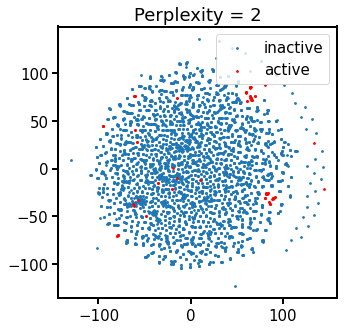

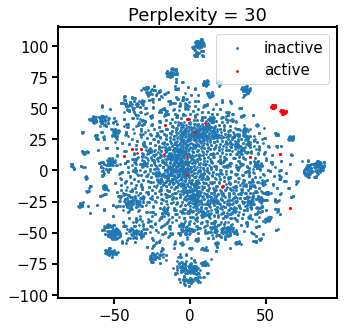

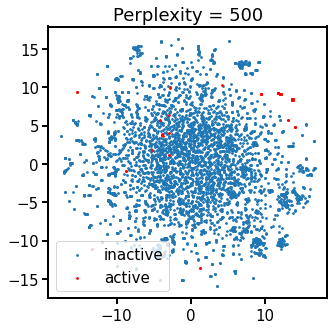

In [ ]:
# Perplexity = 2
TSNE2 = TSNE(n_components=2, perplexity=2)
TSNE2.fit(fp)

x_p2_active = []
y_p2_active = []
x_p2_inactive = []
y_p2_inactive = []
for i in range(0,len(TSNE2.embedding_[:,1])):
  if labels[i]==1:
    x_p2_active.append(TSNE2.embedding_[i,0])
    y_p2_active.append(TSNE2.embedding_[i,1])
  else:
    x_p2_inactive.append(TSNE2.embedding_[i,0])
    y_p2_inactive.append(TSNE2.embedding_[i,1])

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Perplexity = 2')
ax.scatter(x_p2_inactive, y_p2_inactive, s=3, label='inactive') 
ax.scatter(x_p2_active, y_p2_active, color='red', s= 3, label='active')
ax.legend()

# perplexity = 30
TSNE30 = TSNE(n_components=2, perplexity=30)
TSNE30.fit(fp)

x_p30_active = []
y_p30_active = []
x_p30_inactive = []
y_p30_inactive = []
for i in range(0,len(TSNE30.embedding_[:,1])):
  if labels[i]==1:
    x_p30_active.append(TSNE30.embedding_[i,0])
    y_p30_active.append(TSNE30.embedding_[i,1])
  else:
    x_p30_inactive.append(TSNE30.embedding_[i,0])
    y_p30_inactive.append(TSNE30.embedding_[i,1])

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Perplexity = 30')
ax.scatter(x_p30_inactive, y_p30_inactive, s=3, label='inactive') 
ax.scatter(x_p30_active, y_p30_active, color='red', s= 3, label='active')
ax.legend()

#perplexity = 500

TSNE500 = TSNE(n_components=2, perplexity=500)
TSNE500.fit(fp)

x_p500_active = []
y_p500_active = []
x_p500_inactive = []
y_p500_inactive = []
for i in range(0,len(TSNE500.embedding_[:,1])):
  if labels[i]==1:
    x_p500_active.append(TSNE500.embedding_[i,0])
    y_p500_active.append(TSNE500.embedding_[i,1])
  else:
    x_p500_inactive.append(TSNE500.embedding_[i,0])
    y_p500_inactive.append(TSNE500.embedding_[i,1])

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Perplexity = 500')
ax.scatter(x_p500_inactive, y_p500_inactive, s=3, label='inactive') 
ax.scatter(x_p500_active, y_p500_active, color='red', s= 3, label='active')
ax.legend()



What differences do you see between the 3 t-SNE plots? What patterns do you observe in the perplexity = 30 plot?

In [ ]:
#The clustering patterns are different for each perplexity
#the lowest perplexiy graph has most disperse clusters
#interestingly, perplexity=30 lends to the most distinct clusters

#Not only does perplexity=30 lend to the best inactive compound clustering, but 
#active compounds are also clustered best, hence it is the most informative method





2


### 2.3 (15 points) Are the low dimensional embeddings meaningful?

Split the data into 10 folds. For each fold, train on the other 9 folds and validate on the last fold. Record your prediction.

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

X = fp
fp
kf.get_n_splits(X,labels)
splits = kf.split(X,labels)


TP = []
TN = []
FP = []
FN = []

for train_index, test_index in list(kf.split(X, labels)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = labels[train_index], labels[test_index]
  
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  for i in range(0,len(y_test)):
    if y_test[i] == 0:
      if y_pred[i] == 0:
        TN.append(test_index[i])
      else:
        FN.append(test_index[i])
    else:
      if y_pred[i] == 1:
        TP.append(test_index[i])
      else:
        FP.append(test_index[i])




Classify your predictions into True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN).

In [ ]:
#done in loop above

[46, 53, 59, 64, 65, 78, 61, 67, 73, 0, 38, 51, 56, 1, 52, 74, 75, 77, 39, 70, 43, 47, 69, 35, 45, 55, 66]


Plot the 2D t-SNE embeddings (perplexity = 30) colored by the four classification classes.

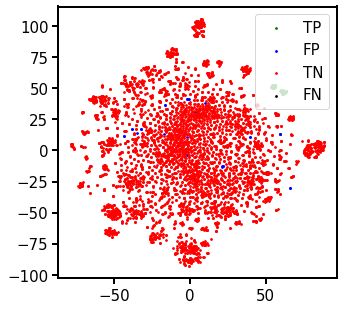

In [ ]:
X = TSNE30.embedding_

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[[TP],0], X[[TP],1], s=3,color = 'green', label='TP') 
ax.scatter(X[[FP],0], X[[FP],1], s=3,color = 'blue', label='FP') 
ax.scatter(X[[TN],0], X[[TN],1], s=3,color = 'red', label='TN') 
ax.scatter(X[[FN],0], X[[FN],1], s=3,color = 'black', label='FN') 

ax.legend()

What pattern do you observe? 

In [ ]:
#All FPs are outside of the TP clusters and there were no FNs